In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
df = pd.read_csv('age_gender.csv')


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cpu


In [ ]:
df['pixel_count'] = df['pixels'].apply(lambda x: len(x.split()))
print(df['pixel_count'].value_counts())
df = df[df['pixel_count'] == 2304].copy()
df.drop(columns=['pixel_count'], inplace=True)

pixel_count
2304    23705
Name: count, dtype: int64


# **GenderCNN**

In [ ]:
class GenderCNN(nn.Module):
    def __init__(self):
        super(GenderCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc(x)
        return x

model = GenderCNN().to(device)

In [ ]:
pixels = np.stack(df['pixels'].apply(lambda x: np.array(x.split(), dtype=np.uint8).reshape(48, 48))) / 255.0
genders = df['gender'].values

pixels = np.expand_dims(pixels, axis=1)

X = torch.tensor(pixels, dtype=torch.float32)
y_gender = torch.tensor(genders, dtype=torch.long)

X_train, X_val, y_gender_train, y_gender_val = train_test_split(
    X, y_gender, test_size=0.2, random_state=42
)

batch_size = 32

train_data = TensorDataset(X_train, y_gender_train)
val_data = TensorDataset(X_val, y_gender_val)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_loader.dataset)}, Validation samples: {len(val_loader.dataset)}")


Training samples: 18964, Validation samples: 4741


# Training and Evaluating GenderCNN

In [ ]:
criterion_gender = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

def train(model, train_loader, optimizer, criterion_gender, device):
    model.train()
    total_loss = 0

    for images, genders in train_loader:
        images, genders = images.to(device), genders.to(device)

        optimizer.zero_grad()
        gender_preds = model(images)
        loss_gender = criterion_gender(gender_preds, genders)
        loss_gender.backward()
        optimizer.step()

        total_loss += loss_gender.item()

    return total_loss / len(train_loader)


In [ ]:
def evaluate(model, val_loader, criterion_gender, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, genders in val_loader:
            images, genders = images.to(device), genders.to(device)

            outputs = model(images)
            loss = criterion_gender(outputs, genders)

            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == genders).sum().item()
            total += genders.size(0)

    avg_loss = total_loss / len(val_loader)
    accuracy = correct / total * 100

    return avg_loss, accuracy

In [ ]:
num_epochs = 5
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion_gender, device)
    train_losses.append(train_loss)

    val_loss, val_accuracy = evaluate(model, val_loader, criterion_gender, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch 1/5, Train Loss: 0.6623, Val Loss: 0.5978, Val Accuracy: 71.15%
Epoch 2/5, Train Loss: 0.5940, Val Loss: 0.4852, Val Accuracy: 77.22%
Epoch 3/5, Train Loss: 0.5063, Val Loss: 0.4035, Val Accuracy: 81.12%
Epoch 4/5, Train Loss: 0.4497, Val Loss: 0.3894, Val Accuracy: 82.54%
Epoch 5/5, Train Loss: 0.4158, Val Loss: 0.3448, Val Accuracy: 83.99%


# Plotting Loss and Accuracy Curves

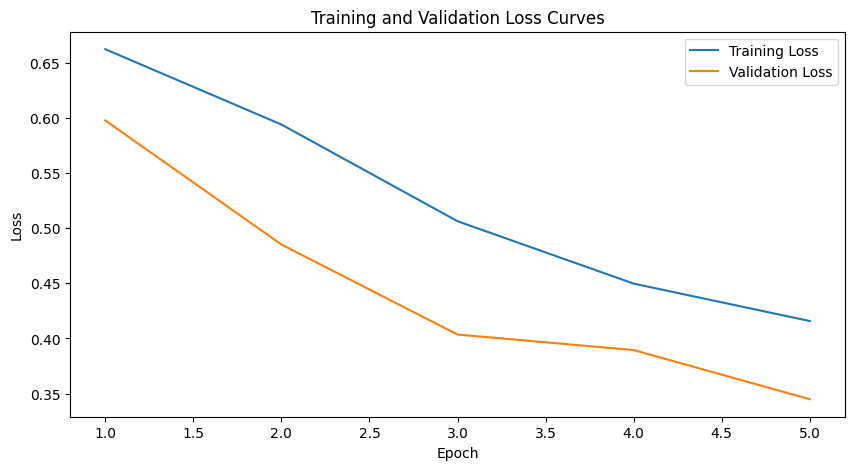

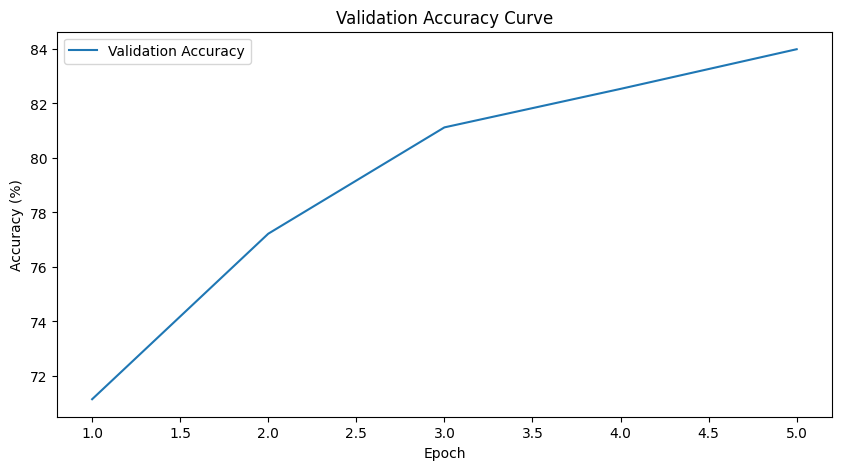

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy') # Using val_accuracies
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Curve')
plt.legend()
plt.show()

# Compare Accuracy Between Age Ranges

In [ ]:
ages = df['age'].values
ages_tensor = torch.tensor(ages, dtype=torch.int32)

_, ages_val = train_test_split(ages_tensor, test_size=0.2, random_state=42)

def evaluate_split(model, val_loader, criterion_gender, device, ages_val):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    correct_baby = 0
    total_baby = 0
    correct_non_baby = 0
    total_non_baby = 0

    with torch.no_grad():
        for batch_idx, (images, genders) in enumerate(val_loader):
            images, genders = images.to(device), genders.to(device)

            outputs = model(images)
            loss = criterion_gender(outputs, genders)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == genders).sum().item()
            total += genders.size(0)

            age_batch = ages_val[batch_idx * val_loader.batch_size : (batch_idx + 1) * val_loader.batch_size]

            baby_mask = age_batch <= 2
            non_baby_mask = age_batch > 2

            correct_baby += (predicted[baby_mask] == genders[baby_mask]).sum().item()
            total_baby += baby_mask.sum().item()

            correct_non_baby += (predicted[non_baby_mask] == genders[non_baby_mask]).sum().item()
            total_non_baby += non_baby_mask.sum().item()

    avg_loss = total_loss / len(val_loader)
    accuracy = correct / total * 100

    baby_accuracy = (correct_baby / total_baby * 100) if total_baby > 0 else 0
    non_baby_accuracy = (correct_non_baby / total_non_baby * 100) if total_non_baby > 0 else 0

    return avg_loss, accuracy, baby_accuracy, non_baby_accuracy

val_loss, val_accuracy, baby_acc, non_baby_acc = evaluate_split(model, val_loader, criterion_gender, device, ages_val)

print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
print(f"Baby Accuracy (≤2): {baby_acc:.2f}%")
print(f"Non-Baby Accuracy (>2): {non_baby_acc:.2f}%")

Validation Loss: 0.3448, Validation Accuracy: 83.99%
Baby Accuracy (≤2): 45.31%
Non-Baby Accuracy (>2): 86.69%
